In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib
# %matplotlib notebook

N points with $\{L_i\}$, $X_0 = 1$ en cada iteración $X_i -> 1/N$

1- N points Uniform distributed en N-sphere. 

instead $ log L = log L_{max} - 0.5(x- \mu)^T \Sigma^{-1} (x-\mu)$, use:

   $ log L = log L_{max} - \alpha_d X^{2/d}$ 
   
   where $L_{max}$ and $X$ are unknown. 
   
   where d is the dimensionallity



In [3]:
def samplePoint(dims):    
    u = np.random.normal(0, 1, dims)  
    norm = np.sum(u**2)**0.5
    r = np.random.random()**(1.0/dims)
    x = r*u/norm
    return x

def samplingNSphere(npoints, dims):
    return np.array([samplePoint(dims) for i in range(npoints)])

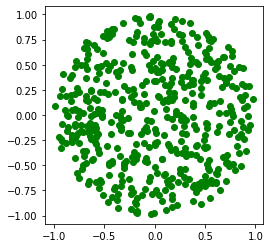

In [4]:
points2d = samplingNSphere(500, 2)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(points2d[:,0], points2d[:,1], c='g')
ax.set_aspect('equal', 'box')

(1000, 3)


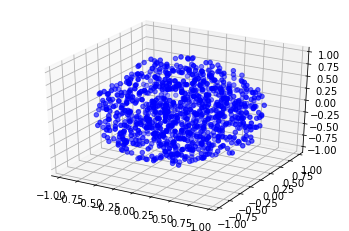

In [5]:
points3d = samplingNSphere(1000, 3)
print(points3d.shape)
fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
ax = fig.gca(projection='3d')
ax.scatter(points3d[:,0], points3d[:,1], points3d[:, 2], c='b')

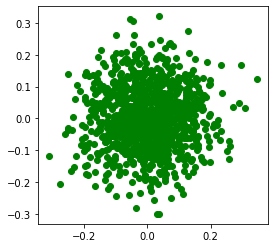

In [8]:
points4d = samplingNSphere(1000, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points4d[:,0], points4d[:,1], c='g')
ax.set_aspect('equal')
# ax = fig.add_subplot(111)
# ax.scatter(points4d[:,2], points4d[:,3], c='r')
# ax.set_aspect('equal')


- Define a spherical Likelihood:
  $logL = -\frac{x^2}{2\sigma^2}$


In [13]:
sigma = 0.5
def sphereVolume(x):
#     return -x**2/2/sigma**2
    return 4/3*np.pi*np.sum(x**2)**(3/2)

def sphereLoglike(x):
#     return -x**2/2/sigma**2
    return -np.sum(x**2)/2/sigma**2

In [22]:
npoints = 100
points3d = samplingNSphere(npoints, 3)
likes = np.zeros((npoints, 1))
for i, p in enumerate(points3d):
    likes[i] = sphereLoglike(p)
volumes = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
    volumes[i] = sphereVolume(p)
    

Text(0.5, 1.0, '$log L = log L_{max} - \x07lpha_d X^{2/d}$')

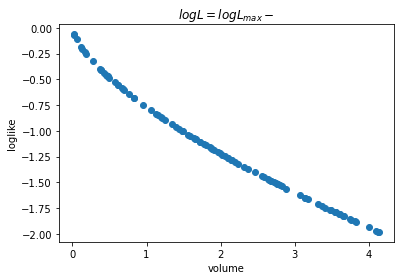

In [28]:
plt.scatter(volumes, likes)
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L = log L_{max} - \alpha_d X^{2/d}$")

In [17]:
samples = np.concatenate([points3d, likes], axis=1)
idx = 10
print(points3d[idx], likes[idx])
samples[idx]

[-0.39643083  0.29998965 -0.34715653] [0.93384298]


array([-0.39643083,  0.29998965, -0.34715653,  0.93384298])

Fit to $ log L = log L_{max} - \alpha_d X^{2/d}$ <- 
   where $L_{max}$ and $X$ are unknown
 
We know that (really?):

- $X_0 = 1$ and $X_i = t_i X_{i-1}$
- Each v point has a $X_i$ unknown and a $L_i$ known. 

- We know the total of samples despite we only use the final set


... and compute the prior volumes (X) and loglikelihood for points generated from
samplingNSphere, and plot those against each other for a few different
dimensions so we can get a feel for the problem. 

Volume is proportional to prior mass

We want to find $L_max$ and $X_{max}$ -> Uniform(0, 1)